In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os, shutil, random, pickle
import cv2
import keras
from sklearn.metrics import confusion_matrix
from keras import models
from keras import layers
from keras import regularizers
from keras import initializers
from keras import activations
from keras import callbacks
from tensorflow.keras import backend as K
tf.compat.v1.disable_eager_execution()

print("TensorFlow version: " + tf.__version__)
print("Keras version: " + keras.__version__)
print("Detected GPUs: " + str(tf.config.experimental.list_physical_devices('GPU')))
print("Detected CPUs: " + str(tf.config.experimental.list_physical_devices('CPU')))

TensorFlow version: 2.9.0
Keras version: 2.9.0
Detected GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Detected CPUs: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


### Configuration

In [2]:
batch_size = 128  # size of the batch
epochs = 30  # model epochs
img_rows = 32  # height of the input images
img_cols = 32  # width of the input images
output_size = 43  # number of classes (size of the one hot vector)

### Load & preprocess data

In [3]:
home = '/Users/kamil/Library/CloudStorage/OneDrive-AkademiaGórniczo-Hutniczaim.StanisławaStaszicawKrakowie/Programming/Data/tsd'
models_dir = '/Users/kamil/Library/CloudStorage/OneDrive-AkademiaGórniczo-Hutniczaim.StanisławaStaszicawKrakowie/Programming/Data/tsd/model'
model_name = 'tsd_class_v11_mac.h5'
data_dir = "data_preprocessed.pickle"

In [4]:
# raw data & variables
data = pd.read_pickle(os.path.join(home, data_dir))

x_train = data['x_train']
y_train = data['y_train']

x_test = data['x_test']
y_test = data['y_test']

x_valid = data['x_validation']
y_valid = data['y_validation']

labels = data['labels']

### Data visualization

In [5]:
def decode_one_hot(one_hot):
    return np.where(one_hot == 1)[0][0]

In [6]:
def percentage_one_hot(one_hot):
    return round(one_hot*100, 2)

In [7]:
def show_class_example(x_data, y_data, labels, c):
    assert len(x_data) == len(y_data)
    
    f,ax = plt.subplots(1, 2)
    f.set_size_inches(10, 5)
    f_index = 0
    
    while True:
        index = random.randint(0, len(y_data))
        if decode_one_hot(y_data[index]) == c[f_index]:
            ax[f_index].set_title(labels[c[f_index]])
            ax[f_index].imshow(x_data[index])
            f_index += 1
        
        if f_index == 2:
            break

In [8]:
def show_sample(shape, x_data, y_data, labels):
    assert shape[0] > 1 and shape[1] >1
    assert len(x_data) == len(y_data)
    
    height = 4*shape[0]
    width = 4*shape[1]
    
    f, ax = plt.subplots(shape[0], shape[1])
    f.set_size_inches(width, height)
    for y in range(shape[0]):
        for x in range(shape[1]):
            index = random.randint(0, len(x_data))
            ax[y][x].set_title(labels[decode_one_hot(y_data[index])])
            ax[y][x].imshow(x_data[index])

In [ ]:
show_sample((10, 10), x_test, y_test, labels)

### Model

In [7]:
model = models.Sequential()

# 1st layer
model.add(layers.Conv2D(48, (3, 3), 
                        input_shape=(img_rows, img_cols, 3), 
                        kernel_initializer=initializers.GlorotNormal(),
                        kernel_regularizer=regularizers.L2(2e-4), 
                        activation=layers.PReLU(),
                        padding="same")
         )
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Dropout(.18))

# 2nd layer
model.add(layers.Conv2D(16, (3, 3), 
                        kernel_initializer=initializers.GlorotNormal(),
                        kernel_regularizer=regularizers.L2(2e-4), 
                        activation=layers.PReLU(), 
                        padding="same")
         )
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Dropout(.18))
model.add(layers.Flatten())

# 3rd layer
model.add(layers.Dense(2*output_size, 
                        kernel_initializer=initializers.GlorotNormal(),
                        kernel_regularizer=regularizers.L2(2e-4), 
                        activation=layers.PReLU())
         )
model.add(layers.BatchNormalization())
model.add(layers.Dropout(.18))

# 4th layer
model.add(layers.Dense(2*output_size, 
                        kernel_initializer=initializers.GlorotNormal(),
                        kernel_regularizer=regularizers.L2(2e-4), 
                        activation=layers.PReLU())
         )
model.add(layers.Dropout(.18))

# 5th (output) layer
model.add(layers.Dense(output_size, activation='sigmoid'))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              metrics=['acc']
             )

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 48)        50496     
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 48)       192       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 48)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 10, 10, 48)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 16)        8528      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 3, 16)        

In [11]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size, 
    epochs=epochs,
    #steps_per_epoch=train_size/batch_size,
    callbacks=[
        #callbacks.EarlyStopping(min_delta=0.1, patience=5),
        callbacks.ModelCheckpoint(os.path.join(models_dir, model_name), save_freq="epoch", verbose=0)
    ],
    validation_data=(x_valid, y_valid)
)

Train on 73000 samples, validate on 5000 samples
Epoch 1/30


2023-02-24 09:45:38.532363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 09:45:38.541456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


73000/73000 [==============================] - ETA: 0s - loss: 0.1966 - acc: 0.9606

/Users/kamil/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-02-24 09:46:04.956178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


73000/73000 [==============================] - 27s 372us/sample - loss: 0.1966 - acc: 0.9606 - val_loss: 0.1154 - val_acc: 0.9876
Epoch 2/30
  128/73000 [..............................] - ETA: 31s - loss: 0.2459 - acc: 0.9531

2023-02-24 09:46:05.594401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 09:46:05.600621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 09:46:05.608090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 09:46:05.616495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 09:46:05.624653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 09:46:05.632210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 09:46:05.639642: I tensorflow/core/grappler/optimizers/cust

73000/73000 [==============================] - 27s 367us/sample - loss: 0.1933 - acc: 0.9605 - val_loss: 0.1190 - val_acc: 0.9872
Epoch 3/30
73000/73000 [==============================] - 27s 373us/sample - loss: 0.1944 - acc: 0.9613 - val_loss: 0.1204 - val_acc: 0.9858
Epoch 4/30
73000/73000 [==============================] - 28s 378us/sample - loss: 0.1931 - acc: 0.9615 - val_loss: 0.1249 - val_acc: 0.9858
Epoch 5/30
73000/73000 [==============================] - 28s 387us/sample - loss: 0.1898 - acc: 0.9628 - val_loss: 0.1205 - val_acc: 0.9848
Epoch 6/30
73000/73000 [==============================] - 28s 381us/sample - loss: 0.1903 - acc: 0.9610 - val_loss: 0.1152 - val_acc: 0.9896
Epoch 7/30
73000/73000 [==============================] - 28s 377us/sample - loss: 0.1883 - acc: 0.9621 - val_loss: 0.1179 - val_acc: 0.9862
Epoch 8/30
73000/73000 [==============================] - 28s 377us/sample - loss: 0.1888 - acc: 0.9612 - val_loss: 0.1275 - val_acc: 0.9818
Epoch 9/30
73000/73000 [

In [12]:
model.save(os.path.join(models_dir, model_name))

In [10]:
model = keras.models.load_model(os.path.join(models_dir, model_name))

Instructions for updating:
Colocations handled automatically by placer.
Metal device set to: Apple M1


2023-02-24 09:45:27.493808: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-24 09:45:27.493938: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-24 09:45:27.499397: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-02-24 09:45:27.505415: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-24 09:45:27.505850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 09:45:27.523004: I tensorflow/core/grappler/optimizers/custom_graph

### Results

In [12]:
def plot_comparison(value, val_value, metric):
    plt.clf()
    plt.figure(figsize=(25,5))
    epochs = range(len(value))
    plt.plot(epochs, value, 'bo', label=f"Training {metric}")
    plt.plot(epochs, val_value, 'b', label=f"Validation {metric}")
    plt.title(f"Comparison of Training and Validation {metric}")
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [13]:
def print_evaluation(model, x_test, y_test):
    loss, acc = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    print(f"Test accuracy: {round(acc * 100, 2)}%")
    print(f"Test loss: {round(loss, 2)}")

In [14]:
def print_confusion_matrix(model, x_test, y_test, labels):
    y_pred = model.predict(x_test, verbose=0, batch_size=batch_size)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    
    cm = confusion_matrix(y_test, y_pred)
    ticks=np.linspace(0, output_size, num=output_size+1)
    plt.clf()
    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='none')
    plt.colorbar()
    plt.xticks(ticks, fontsize=6)
    plt.xlabel("Predicted")
    plt.yticks(ticks, fontsize=6)
    plt.ylabel("True")
    plt.grid(True)
    plt.show()

In [15]:
print_evaluation(model, x_test, y_test)

Test accuracy: 98.8%
Test loss: 0.1


/Users/kamil/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-02-24 10:00:32.144579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<Figure size 640x480 with 0 Axes>

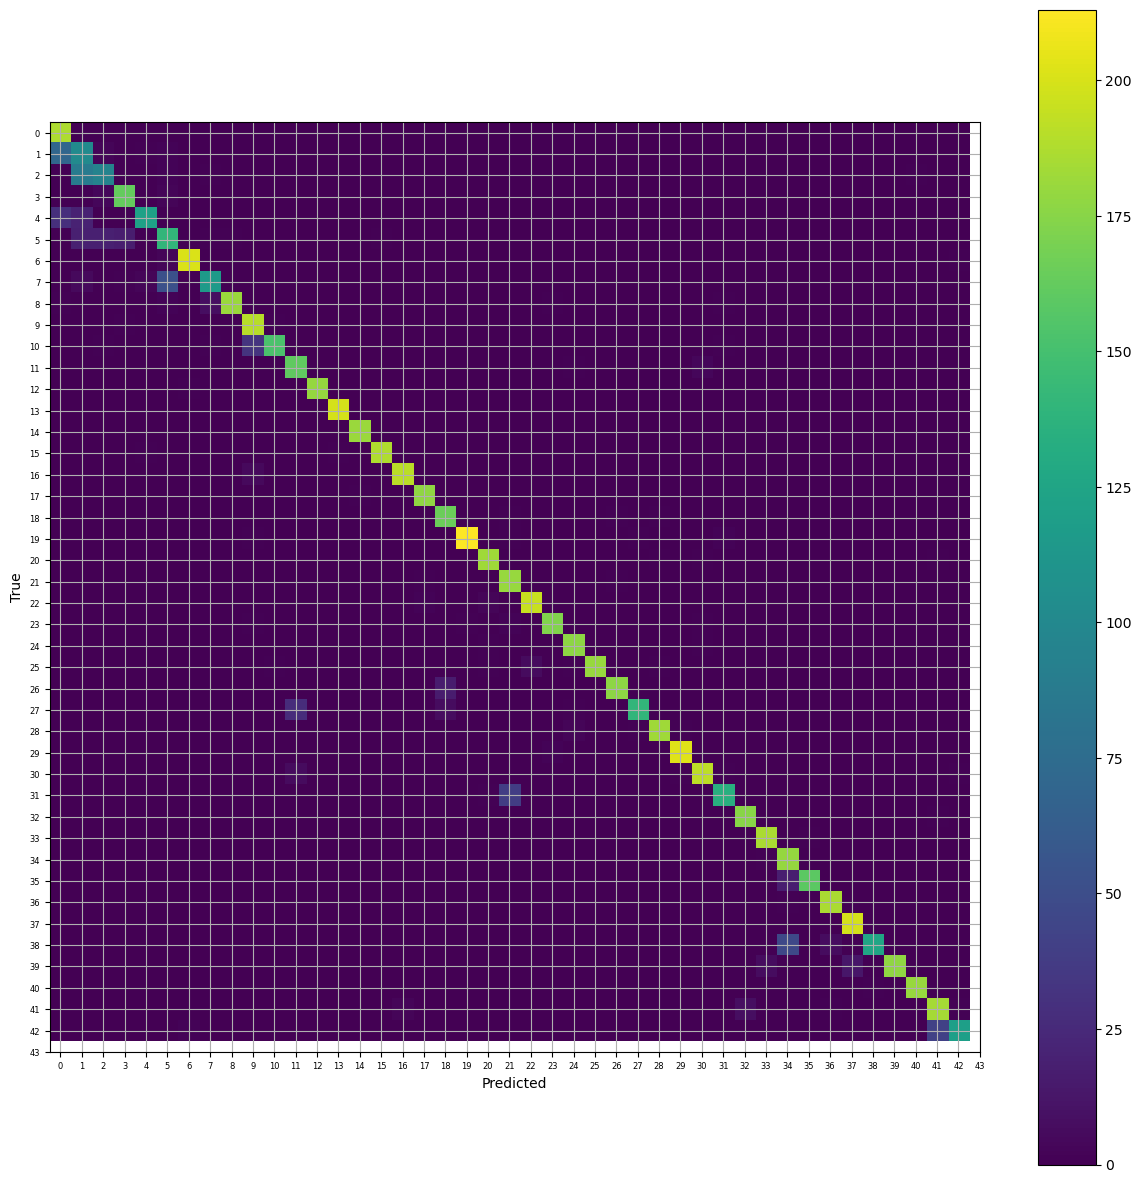

In [16]:
print_confusion_matrix(model, x_test, y_test, labels)

<Figure size 640x480 with 0 Axes>

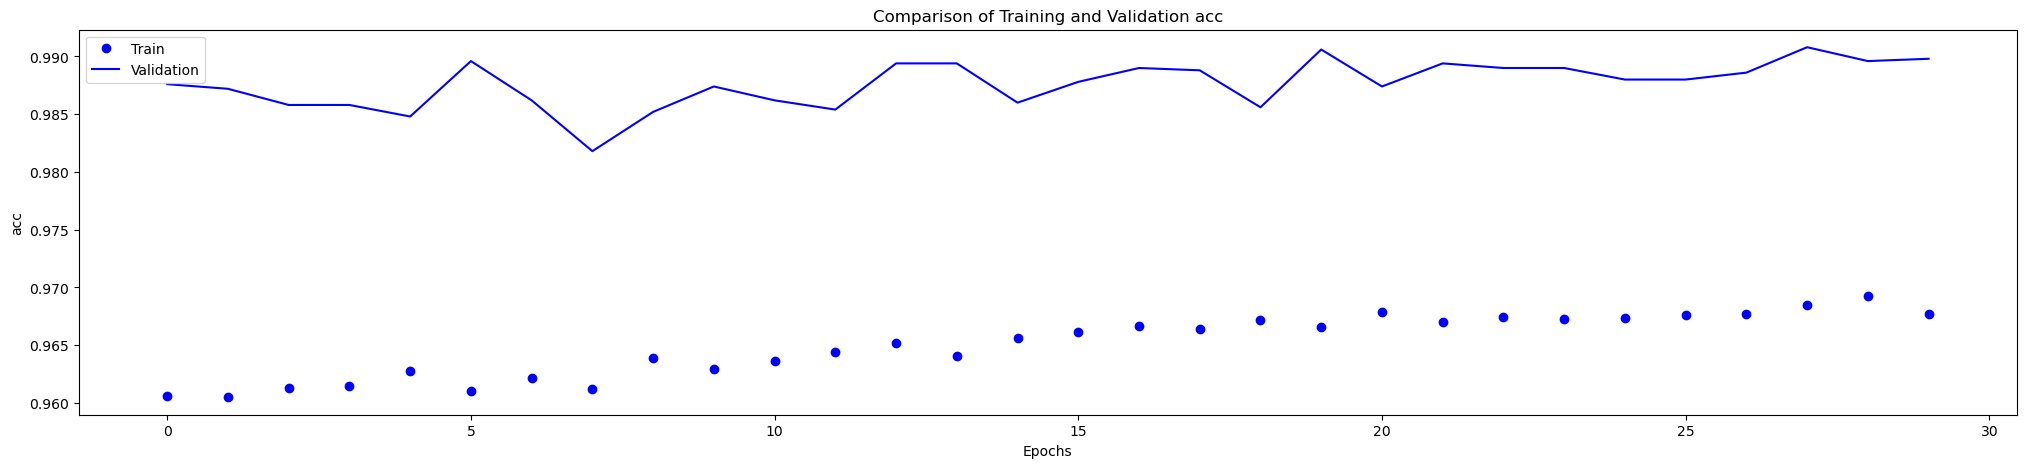

In [17]:
plot_comparison(history.history['acc'], history.history['val_acc'], "acc")

<Figure size 640x480 with 0 Axes>

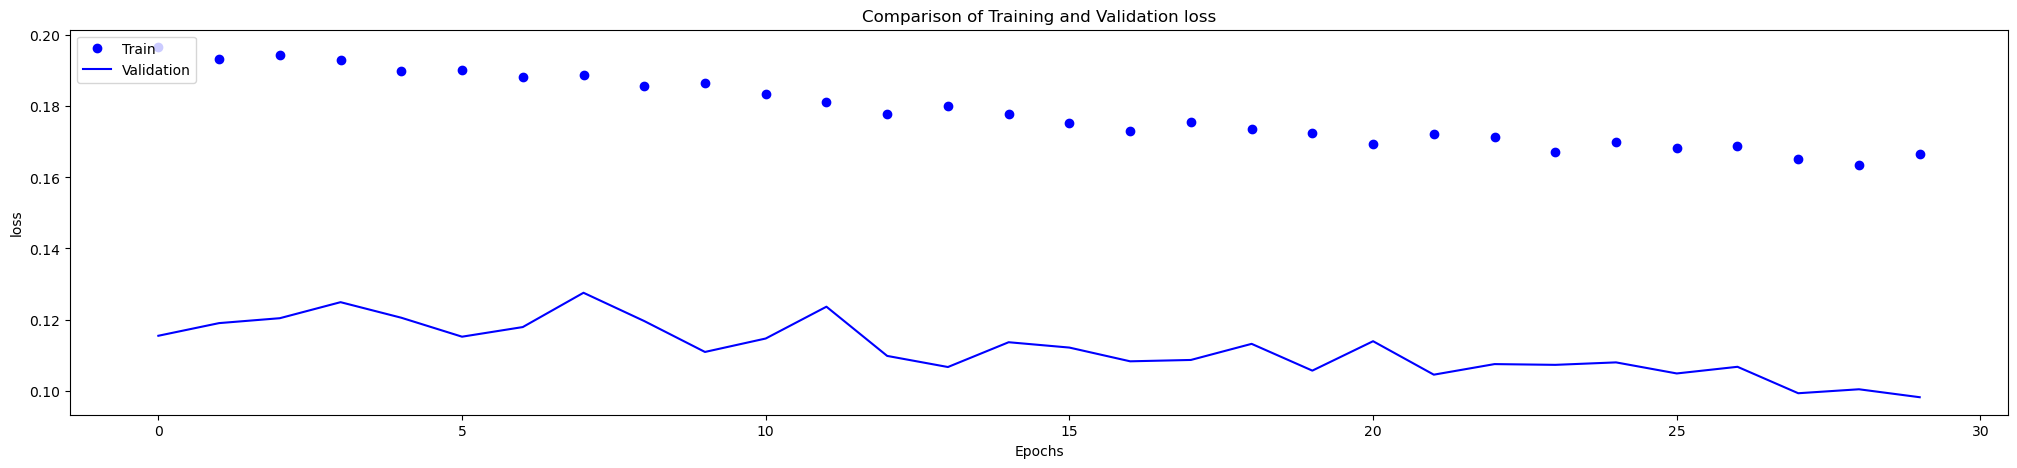

In [18]:
plot_comparison(history.history['loss'], history.history['val_loss'], "loss")

### Visualizing activation layers

In [19]:
def visualize_layers(model, img):
    layer_outputs = [layer.output for layer in model.layers if len(layer.output_shape) > 2 and "dropout" not in layer.name]
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(img.reshape((1, img_rows, img_cols, 3)), verbose=0)

    layer_names = []
    images_per_row = 16
    for layer in layer_outputs:
        layer_names.append(layer.name)
        try:
            if layer.filters < images_per_row:
                images_per_row = layer.filters
        except:
            pass
        
    plt.figure(figsize=(1, 1))
    plt.title("Input image", fontsize=10)
    plt.imshow((img+1)/2.0)

    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, size * images_per_row))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                if channel_image.std() != 0:
                    channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()

/Users/kamil/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-02-24 10:00:33.790675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


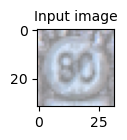

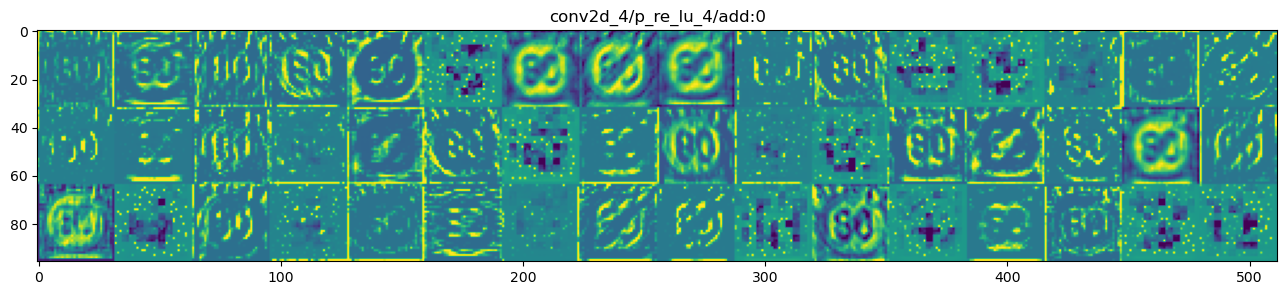

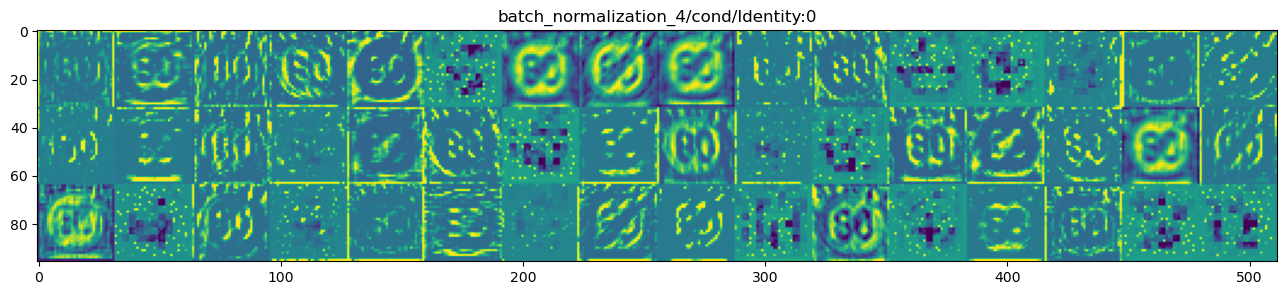

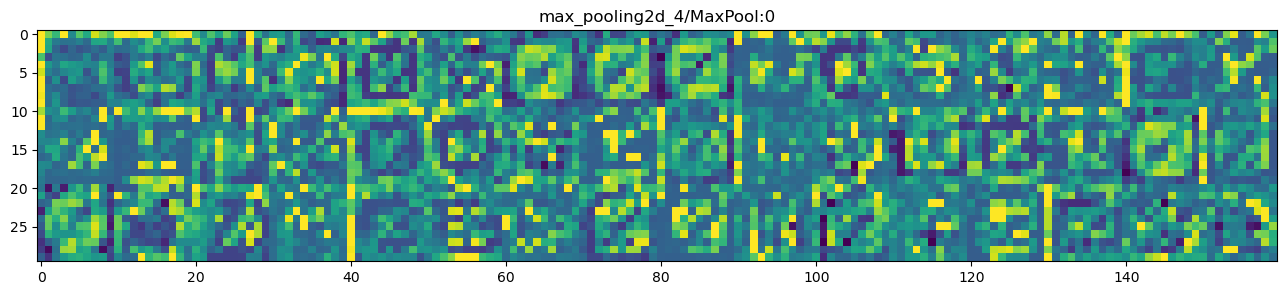

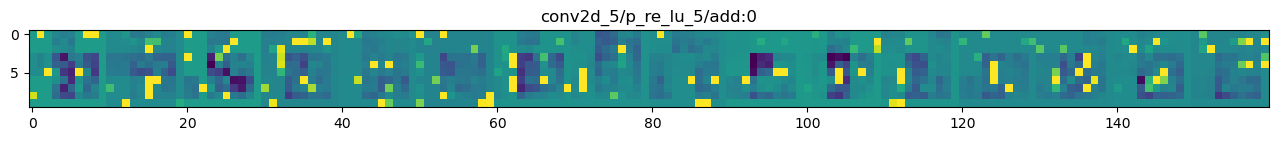

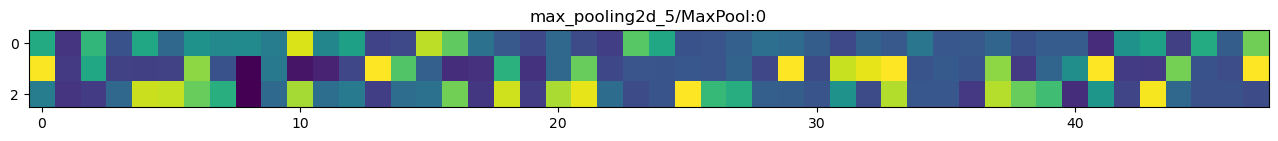

In [20]:
visualize_layers(model, x_test[2])

2023-02-24 10:00:34.458944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


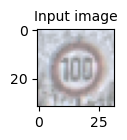

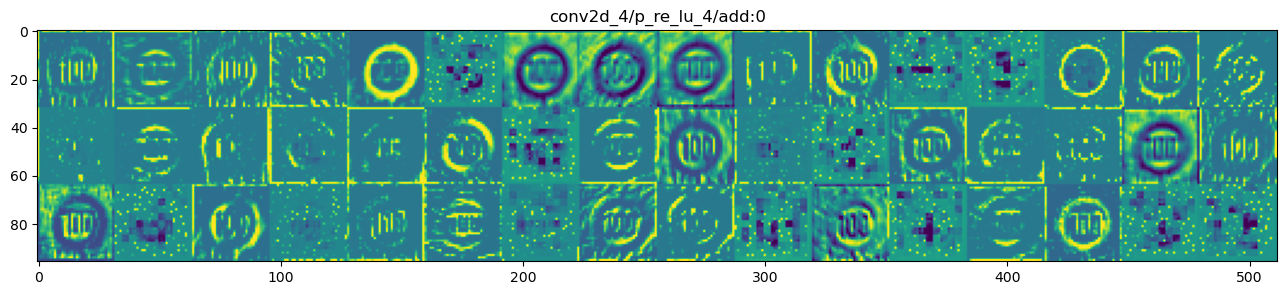

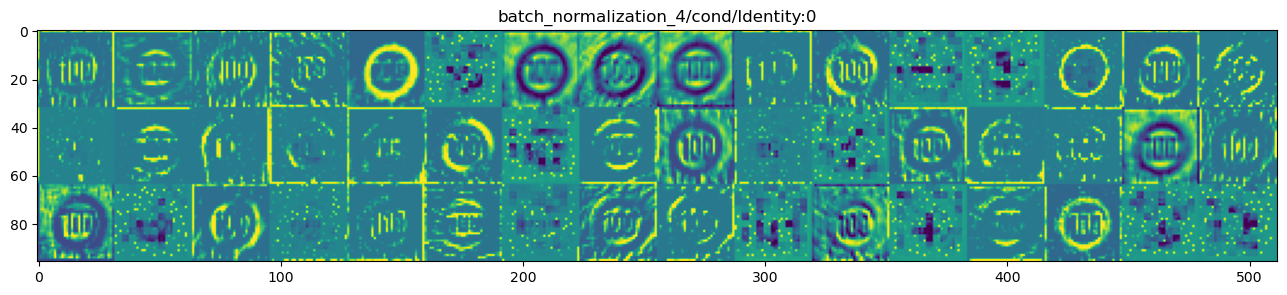

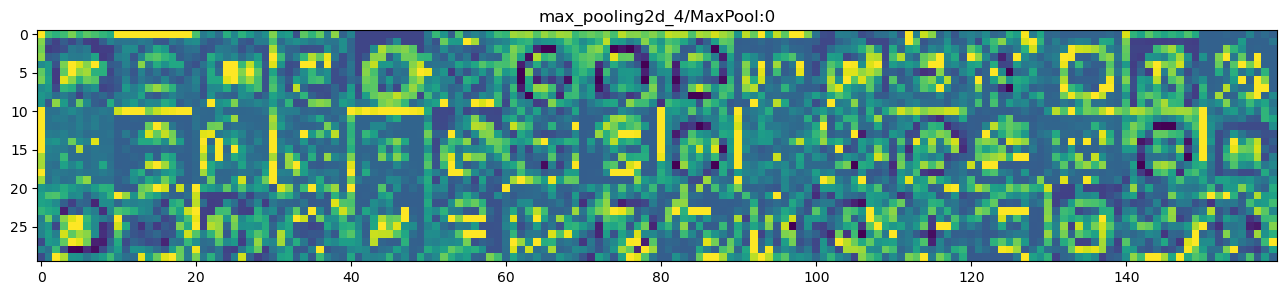

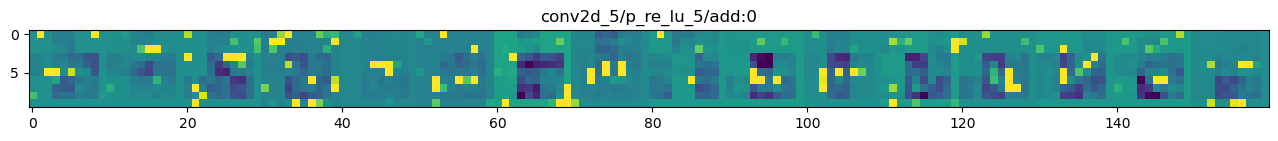

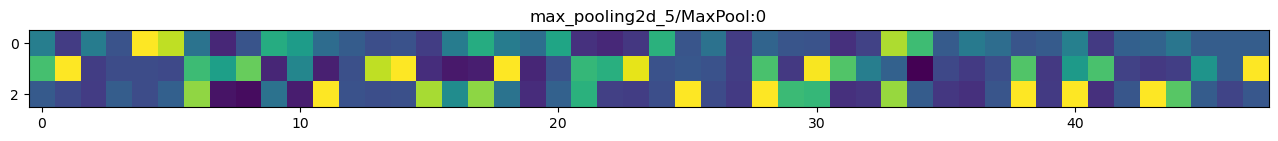

In [21]:
visualize_layers(model, x_test[140])

2023-02-24 10:00:35.095510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


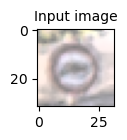

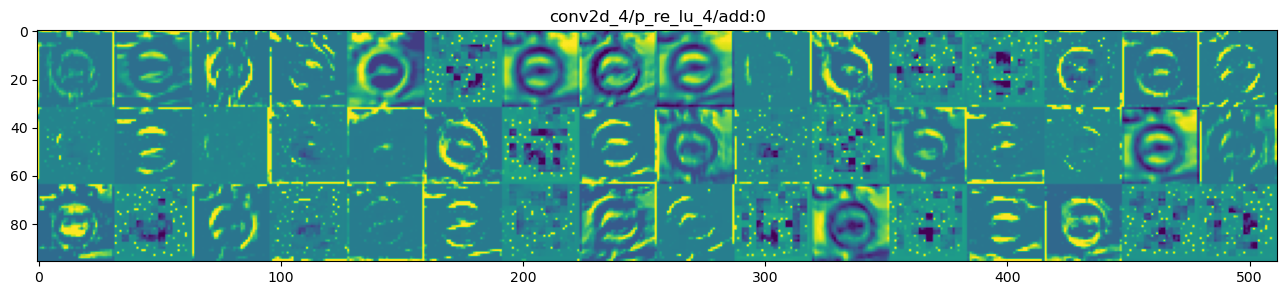

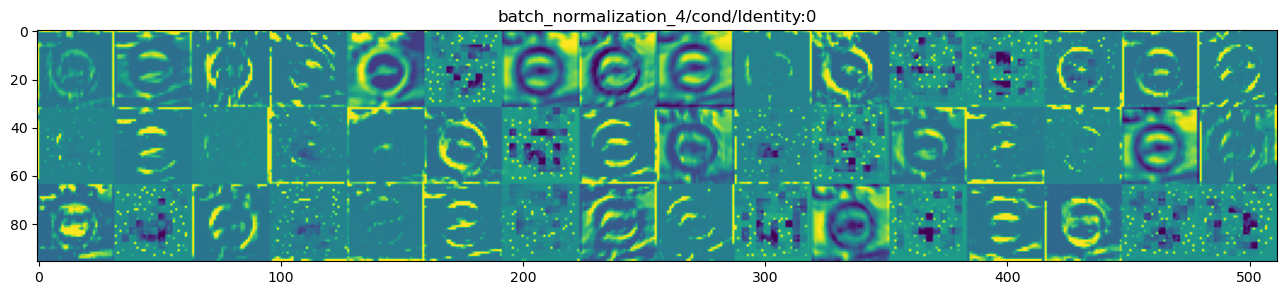

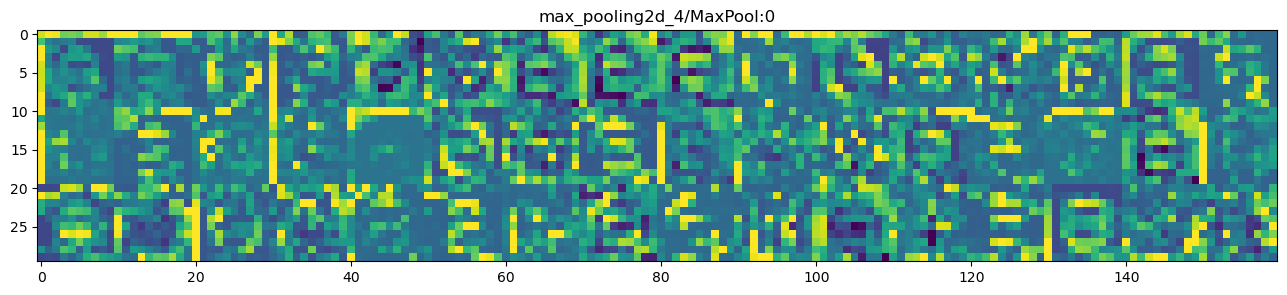

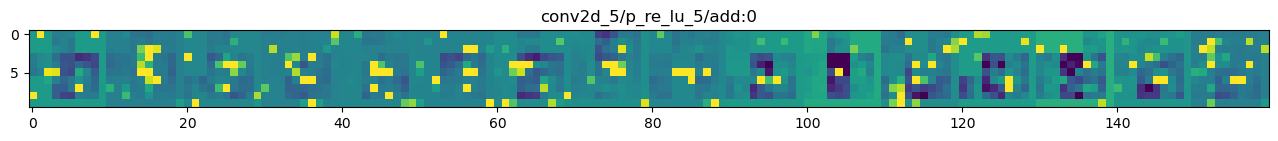

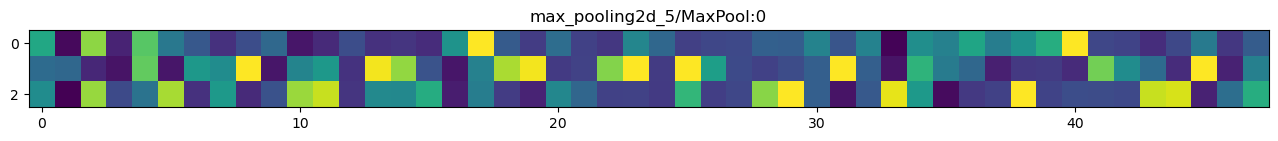

In [22]:
visualize_layers(model, x_test[36])

### Visualizing filters

In [23]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [24]:
def generate_pattern(model, layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 10 + 128.

    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

In [25]:
def rows_cols(value):
    assert value >= 1
    
    rows = 1
    cols = value
    for i in range(2, value//2+1):
        if value % i == 0:
            if np.abs(i - int(value / i)) < np.abs(rows - cols):
                rows = i
                cols = int(value / i)
    
    return rows, cols

In [26]:
def visualize_filters(model):
    margin = 3
    size = 32
    layers = [layer.name for layer in model.layers if len(layer.output_shape) > 2 and "conv" in layer.name]
    for layer_name in layers: 
        f_count = model.get_layer(layer_name).filters
        rows, cols = rows_cols(f_count)

        results = np.zeros((rows * size + (rows-1) * margin, cols * size + (cols-1) * margin, 3), dtype=np.uint8)
        for i in range(rows):
            for j in range(cols):
                filter_img = generate_pattern(model, layer_name, j + (i * cols), size=size)
                horizontal_start = i * size + i * margin
                horizontal_end = horizontal_start + size
                vertical_start = j * size + j * margin
                vertical_end = vertical_start + size
                results[horizontal_start : horizontal_end, vertical_start : vertical_end, : ] = filter_img

        print("Layer name: " + layer_name)
        plt.figure(figsize=(size / 2, size / 2))
        plt.imshow(results)
        plt.show()

2023-02-24 10:00:35.780497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 10:00:36.005970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 10:00:36.211679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 10:00:36.427248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 10:00:36.633686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 10:00:36.851634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 10:00:37.076563: I tensorflow/core/grappler/optimizers/cust

Layer name: conv2d_4


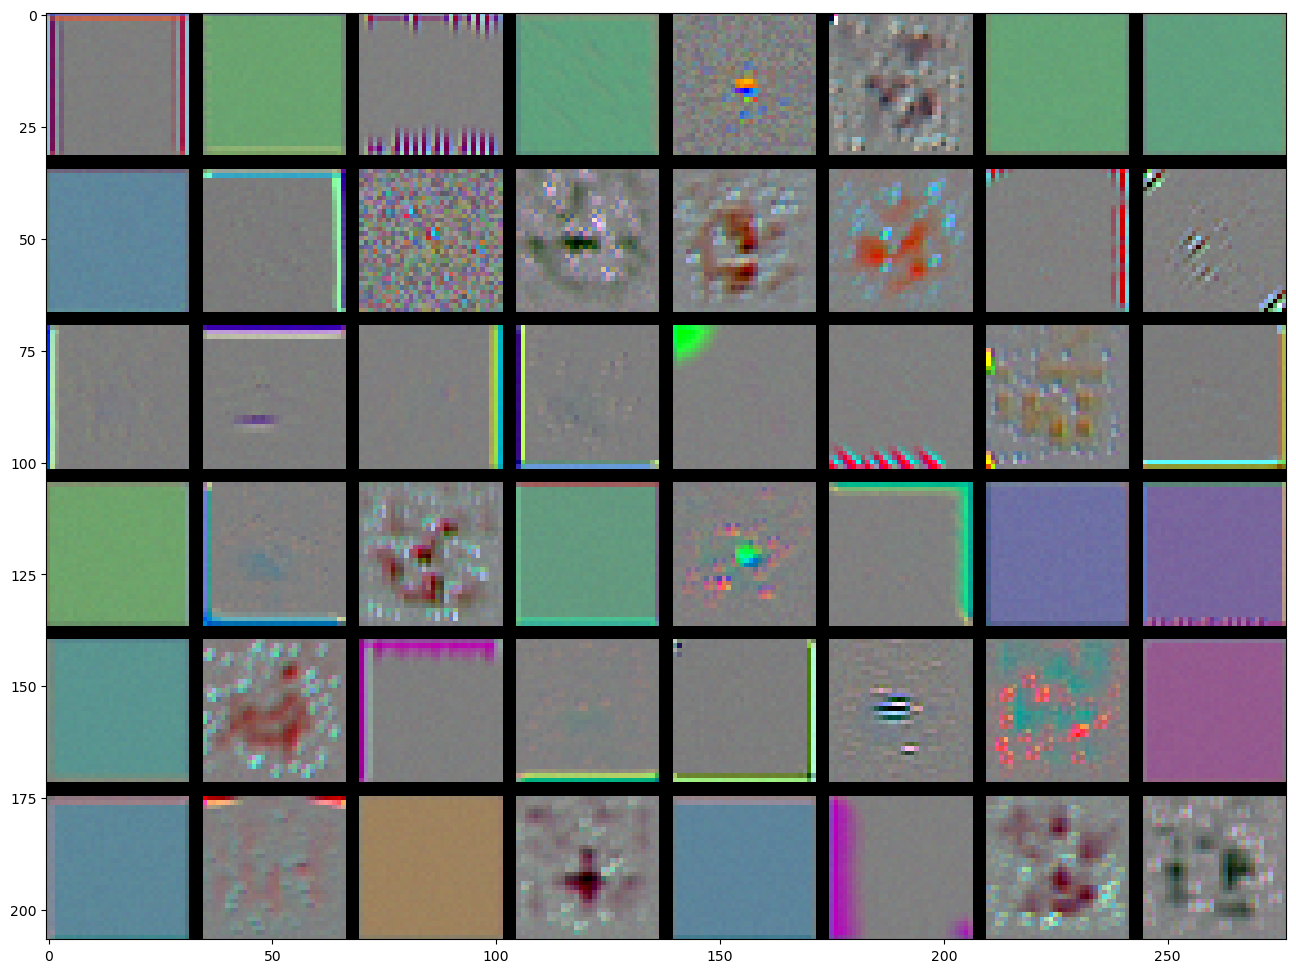

2023-02-24 10:00:47.099446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 10:00:47.698004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 10:00:48.250245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 10:00:48.822372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 10:00:49.399000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 10:00:49.996447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 10:00:50.582961: I tensorflow/core/grappler/optimizers/cust

Layer name: conv2d_5


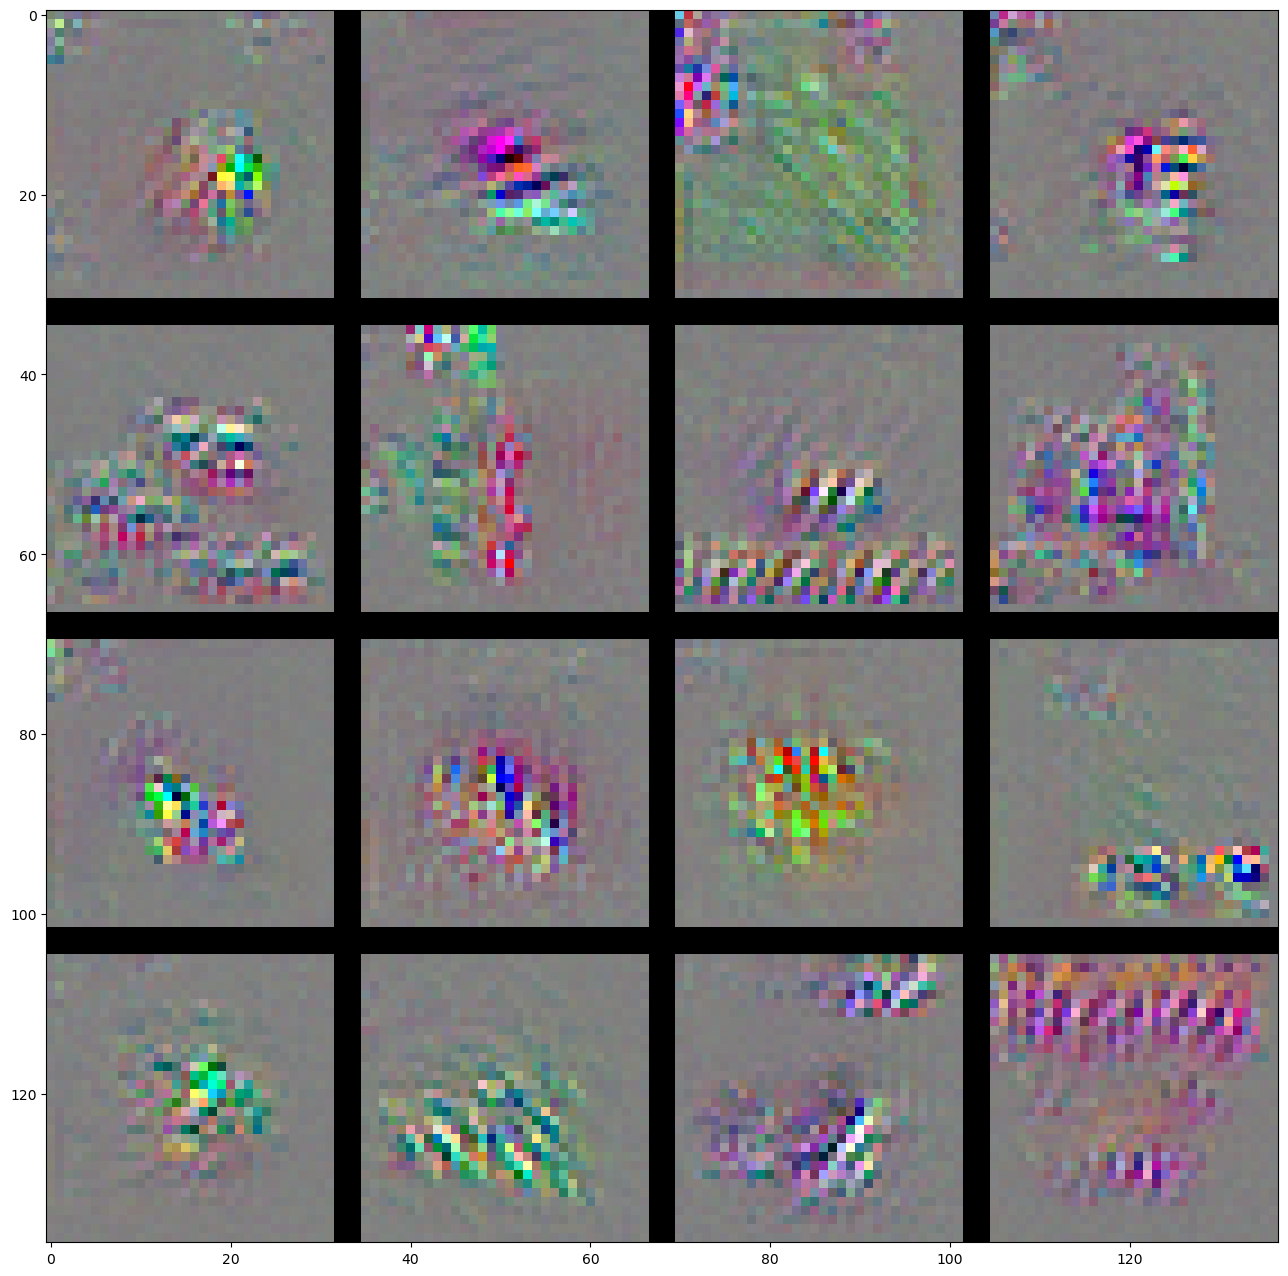

In [27]:
visualize_filters(model)